In [2]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, ttest_rel, ttest_1samp, pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score, permutation_test_score, LeaveOneOut
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, pairwise_distances
from imblearn.over_sampling import SMOTE 

%matplotlib inline

In [3]:
 
def make_TR(input_list):
    return [round(x/2) for x in input_list]
    
def clean_time_point(input_list):
    
    output_list = []
    
    # remove out of bounds
    bounds = [15, 1493-15]
    output_list = [item for item in input_list if bounds[0] <= item <= bounds[1]]

    # remove each run end
    for TR_i in [0, 250, 549, 742, 946, 1232, 1493]:
        output_list = [item for item in output_list if ( TR_i+15 <= item) or( item <= TR_i-15)]

    return output_list



In [4]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)
all_brain_data.shape

(37, 1493, 200)

In [11]:
roi_name = '7Networks_LH_Default_PFC_8'
sub_list = list(range(13, 51))
run_list = [1,2,3,4,5,6]
sub_list.remove(21)

seed_roi_index = 89

results = []
for sub_idx, sub  in enumerate(sub_list):
    
    # change time point（秒）
    sub_time_file = f'/Users/li/Desktop/debate/behavedata/during_scan/combined_6runs_filter_diff/subject_{sub}_rate_diff.csv'
    sub_time = pd.read_csv(sub_time_file)

    change_time = list(sub_time['time'][1:])
    change_time = make_TR(change_time)
    
    # change_time = remove_out_of_bounds(change_time)
    change_time = clean_time_point(change_time)
    
    pre_rate = list(sub_time['rate'][:-1])
    change = list(sub_time['rate_diff'][1:])

    # sub's brain data
    sub_data = all_brain_data[sub_idx,:,:]

    for i, point in enumerate(change_time):
        
        idx = point
        start_idx = idx -15
        end_idx = idx +15

        seed_data = sub_data[start_idx:end_idx, seed_roi_index]
        other_data = np.delete(sub_data, seed_roi_index, axis=1)
        other_data = other_data[start_idx:end_idx, :]

        correlations = []
        for roi in range(other_data.shape[1]):  # 遍历所有脑区
                corr, _ = pearsonr(seed_data, other_data[:, roi])
                correlations.append(corr)

        
        row_data = {'subject': sub, 'change_time': change_time[i], 'pre_rate': pre_rate[i], 'change': change[i],'type':None}

        for j, r in enumerate(correlations):
            row_data[f'edge_{j+1}'] = r
        
        results.append(row_data)
        
df = pd.DataFrame(results)
df


,subject,change_time,pre_rate,change,type,edge_1,edge_2,edge_3,edge_4,edge_5,...,edge_190,edge_191,edge_192,edge_193,edge_194,edge_195,edge_196,edge_197,edge_198,edge_199
0,13,205,12,1.0,None,-0.119122,-0.122584,-0.315962,0.142411,-0.067097,...,0.043801,0.563052,0.665749,-0.064635,-0.199937,0.159741,0.204705,0.183885,0.068472,-0.031669
1,13,330,13,1.0,None,0.242920,-0.347652,-0.098684,0.142367,-0.488510,...,-0.084055,0.372182,0.726938,0.326739,0.056708,-0.068648,0.006551,0.238409,-0.128463,0.172628
2,13,381,14,-1.0,None,-0.363464,-0.143693,-0.327259,0.223065,-0.204857,...,0.354126,0.557849,0.470951,-0.096962,-0.246909,0.191674,0.218274,-0.374892,-0.198743,-0.323931
3,13,590,13,1.0,None,-0.168892,-0.459676,-0.408823,0.063101,-0.115896,...,0.034978,-0.075295,0.626674,-0.070291,0.071155,0.544004,0.451077,0.290984,0.424497,0.510659
4,13,603,14,-1.0,None,0.050297,-0.234080,-0.273157,0.039002,-0.079481,...,-0.144113,0.079822,0.798107,0.081974,0.300524,0.519289,0.547409,0.216669,0.091754,0.113742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,50,704,10,-2.0,None,-0.365437,-0.285584,-0.299600,0.045278,-0.087721,...,-0.221343,0.584756,0.762579,0.421940,-0.043070,0.655188,0.570516,-0.199910,0.103451,0.400318
598,50,724,8,-1.0,None,-0.253631,-0.163090,-0.336452,0.163801,-0.080441,...,0.002548,0.543511,0.601172,0.646543,0.606082,0.522323,0.413731,-0.197108,0.446770,0.113850
599,50,905,7,-1.0,None,0.110078,-0.272992,-0.325444,0.033518,-0.437567,...,-0.266761,0.284661,0.636001,0.306469,0.523497,0.362205,0.067190,0.046765,0.254358,0.295980
600,50,1084,6,-1.0,None,0.225636,-0.124732,-0.441076,0.423110,-0.273822,...,-0.181348,0.232446,0.232215,0.221141,0.169222,0.420490,0.253099,0.242512,0.360256,0.324891


In [12]:
nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
nw_labels = nw_labels[nw_labels["ROI Label"] != 90].reset_index(drop=True)

default = []
for i in range(199):
    net_name = nw_labels['ROI Name'][i].split('_')[2] 
    if net_name == 'Default':
        default.append(i)
        
print(default)
selete_edge = ['subject','change_time','pre_rate','change','type'] + [f'edge_{i+1}' for i in default ] # 

df_expanded = df[selete_edge]
df_expanded

[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


,subject,change_time,pre_rate,change,type,edge_74,edge_75,edge_76,edge_77,edge_78,...,edge_190,edge_191,edge_192,edge_193,edge_194,edge_195,edge_196,edge_197,edge_198,edge_199
0,13,205,12,1.0,None,0.220576,-0.122274,-0.340454,-0.273620,-0.779632,...,0.043801,0.563052,0.665749,-0.064635,-0.199937,0.159741,0.204705,0.183885,0.068472,-0.031669
1,13,330,13,1.0,None,-0.369346,-0.308366,-0.323064,-0.426215,-0.493835,...,-0.084055,0.372182,0.726938,0.326739,0.056708,-0.068648,0.006551,0.238409,-0.128463,0.172628
2,13,381,14,-1.0,None,-0.546506,-0.364278,-0.665823,-0.511278,-0.463083,...,0.354126,0.557849,0.470951,-0.096962,-0.246909,0.191674,0.218274,-0.374892,-0.198743,-0.323931
3,13,590,13,1.0,None,-0.294801,-0.291978,-0.127129,-0.345193,-0.228854,...,0.034978,-0.075295,0.626674,-0.070291,0.071155,0.544004,0.451077,0.290984,0.424497,0.510659
4,13,603,14,-1.0,None,-0.129106,-0.095638,0.037581,-0.127707,-0.005634,...,-0.144113,0.079822,0.798107,0.081974,0.300524,0.519289,0.547409,0.216669,0.091754,0.113742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,50,704,10,-2.0,None,-0.392681,-0.338584,-0.670624,-0.353305,-0.505644,...,-0.221343,0.584756,0.762579,0.421940,-0.043070,0.655188,0.570516,-0.199910,0.103451,0.400318
598,50,724,8,-1.0,None,-0.211960,-0.260252,-0.556295,-0.136168,-0.564918,...,0.002548,0.543511,0.601172,0.646543,0.606082,0.522323,0.413731,-0.197108,0.446770,0.113850
599,50,905,7,-1.0,None,-0.350809,-0.362232,-0.580660,-0.361415,-0.479050,...,-0.266761,0.284661,0.636001,0.306469,0.523497,0.362205,0.067190,0.046765,0.254358,0.295980
600,50,1084,6,-1.0,None,-0.536994,-0.021156,-0.635339,-0.507500,-0.791729,...,-0.181348,0.232446,0.232215,0.221141,0.169222,0.420490,0.253099,0.242512,0.360256,0.324891


In [13]:
df_expanded = df_expanded.copy()

def set_type(row):
    if row['pre_rate'] > 7 and row['change'] > 0:
        return 1
    elif row['pre_rate'] > 7 and row['change'] < 0:
        return 2
    elif row['pre_rate'] < 7 and row['change'] < 0:
        return 3
    elif row['pre_rate'] < 7 and row['change'] > 0:
        return 4
    else:
        return None  
        
df_expanded['type'] = df_expanded.apply(set_type, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

print(df_expanded.shape)

(543, 50)


In [16]:

X = df_expanded.drop(columns=['subject', 'change_time', 'pre_rate', 'change','type']) 
y = df_expanded['type']  

svm_model = SVC(class_weight='balanced')

loo = LeaveOneOut()
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

print("混淆矩阵:")
y_pred = cross_val_predict(svm_model, X, y, cv=loo)
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)
print()
print("分类报告:")
print(classification_report(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print(f"loo 正确率: {accuracy:.2f}")



置换检验得分: 0.39
置换检验的p值: 0.0010
混淆矩阵:
[[90 58 26 28]
 [70 68 23 27]
 [17  7 27 19]
 [24 14 19 26]]

分类报告:
              precision    recall  f1-score   support

         1.0       0.45      0.45      0.45       202
         2.0       0.46      0.36      0.41       188
         3.0       0.28      0.39      0.33        70
         4.0       0.26      0.31      0.28        83

    accuracy                           0.39       543
   macro avg       0.36      0.38      0.37       543
weighted avg       0.40      0.39      0.39       543

loo 正确率: 0.39


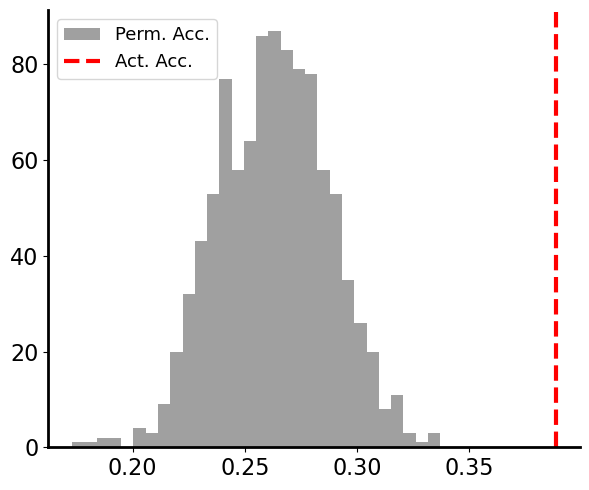

In [48]:

plt.figure(figsize=(6, 5))
# 可视化置换检验结果
plt.hist(permutation_scores, bins=30, alpha=0.75, color='grey', label='Perm. Acc.')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=3, label='Act. Acc.')
plt.xticks(fontsize=16)  # 设置 x 轴刻度字体大小
plt.yticks(fontsize=16)  # 设置 y 轴刻度字体大小

# 去掉上面和左边的框线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 设置 y 轴坐标从 0.05 开始
# plt.ylim(bottom=0.05)

# 加粗左边和下边的轴线
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.legend(loc='best', fontsize=13)
# plt.legend(title="Network", bbox_to_anchor=(1.01, 1), borderaxespad=0, fontsize=12, title_fontsize=13)

plt.tight_layout()
# 保存图像
plt.savefig('/Users/li/Desktop/Figure/6d_DMN.png', dpi=300)
# plt.xlabel('Accuracy Score')
# plt.ylabel('Frequency')
# plt.title('Permutation Test Results')

plt.show()